In [33]:
from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilderNoEcho
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.algorithms import GroundStateEigensolver
from qiskit_nature.runtime import VQEClient
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IBMQ.load_account()
provider = IBMQ.get_provider()

In [44]:
hardware_backend = provider.get_backend('ibmq_quito')

In [31]:
def HEA_aware(num_q, depth):
    circuit = QuantumCircuit(num_q)
    params = ParameterVector("theta", length=num_q * (3 * depth + 2))
    counter = 0
    for q in range(num_q):
        circuit.rx(params[counter], q)
        counter += 1 
        circuit.rz(params[counter], q)
        counter += 1
    for d in range(depth):
        for q in range(num_q - 1):
            gate = QuantumCircuit(num_q)
            gate.rzx(np.pi/2, q, q + 1)
            pass_ = RZXCalibrationBuilderNoEcho(hardware_backend)
            qc_cr = PassManager(pass_).run(gate)
            circuit.compose(qc_cr, inplace=True)
        for q in range(num_q):
            circuit.rz(params[counter], q)
            counter += 1
            circuit.rx(params[counter], q)
            counter += 1 
            circuit.rx(params[counter], q, label="last" if q == num_q - 1 else 'rz')
            counter += 1
    return circuit, params

dist = 0.82
qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()

molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                           driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)

calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem)
ret_1 = np.real(res.total_energies[0])

target_energy = ret_1

In [ ]:
shots = 1024
backend = provider.get_backend('ibmq_qasm_simulator')

qubits = 2
depth = 1
circuit, _ = HEA_aware(qubits, depth)
spsa = SPSA(200)

qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)
numpy_solver = NumPyMinimumEigensolver()

molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                           driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)

runtime_vqe = VQEClient(
    ansatz=circuit,
    optimizer=spsa,
    provider=provider,
    backend=backend,
    shots=shots
) 

runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
runtime_vqe_result_soft = runtime_vqe_groundstate_solver.solve(es_problem)

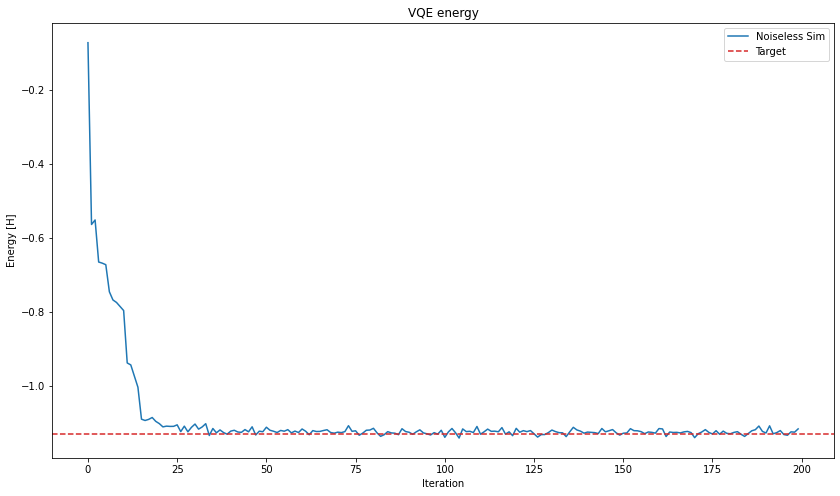

In [45]:
runtime_result_soft = runtime_vqe_result_soft.raw_result
history_soft = runtime_result_soft.optimizer_history
loss_soft = history_soft["loss"]

target_energy = ret_1
plt.figure(figsize=(14, 8))
plt.plot(loss_soft + runtime_vqe_result_soft.nuclear_repulsion_energy, label="Noiseless Sim")
plt.axhline(y=target_energy, color="tab:red", ls="--", label="Target")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [1]:
from qiskit.tools.jupyter import *

%qiskit_version_table